# Non-orthogonal curvilinear coordinates

In this notebook we solve Poisson's equation on a 2D wavy domain, using non-orthogonal basis vectors.

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import Math
from shenfun import *
from shenfun.la import Solver2D

Define the non-orthogonal curvilinear coordinates. Here `psi=(u, v)` are the new coordinates and `rv` is the position vector

$$
\vec{r} = u \mathbf{i} + v\left(1- \frac{\sin 2u}{10} \right) \mathbf{j}
$$

where $\mathbf{i}$ and $\mathbf{j}$ are the Cartesian unit vectors in $x$- and $y$-directions, respectively.

In [2]:
u = sp.Symbol('x', real=True, positive=True)
v = sp.Symbol('y', real=True)
psi = (u, v)
rv = (u, v*(1-sp.sin(2*u)/10))
rv = ()

Now choose basis functions and create tensor product space. Notice that one has to use complex Fourier space and not the real, because the integral measure is a function of u.

In [3]:
N = 20
#B0 = Basis(N, 'C', bc=(0, 0), domain=(0, 2*np.pi))
B0 = Basis(N, 'F', dtype='D', domain=(0, 2*np.pi))
B1 = Basis(N, 'L', bc=(0, 0), domain=(-1, 1))

T = TensorProductSpace(comm, (B0, B1), dtype='D', coordinates=(psi, rv, sp.Q.negative(sp.sin(2*u)-10) & sp.Q.negative(sp.sin(2*u)/10-1)))
p = TrialFunction(T)
q = TestFunction(T)
b = T.coors.get_covariant_basis()

In [4]:
Math(T.coors.latex_basis_vectors(covariant=True, symbol_names={u: 'u', v: 'v'}))

<IPython.core.display.Math object>

Plot the mesh to see the domain.

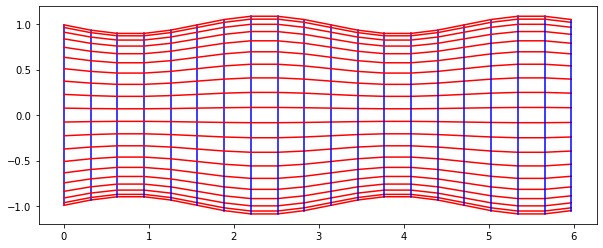

In [5]:
mesh = T.local_curvilinear_mesh()
x, y = mesh
plt.figure(figsize=(10, 4))
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.plot(xi, yi, 'b')
    plt.plot(x[:, i], y[:, i], 'r')

Print the Laplace operator in curvilinear coordinates. We use `replace` to simplify the expression.

In [6]:
dp = div(grad(p))
g = sp.Symbol('g', real=True, positive=True)
replace = [(1-sp.sin(2*u)/10, sp.sqrt(g)), (sp.sin(2*u)-10, -10*sp.sqrt(g)), (5*sp.sin(2*u)-50, -50*sp.sqrt(g))]
Math((dp).tolatex(funcname='p', symbol_names={u: 'u', v: 'v'}, replace=replace))

<IPython.core.display.Math object>

Solve Poisson's equation. First define a manufactured solution and assemble the right hand side

In [7]:
ue = sp.sin(2*u)*(1-v**2)
f = (div(grad(p))).tosympy(basis=ue, psi=psi)
fj = Array(T, buffer=f)
f_hat = Function(T)
f_hat = inner(q, fj, output_array=f_hat)

Then assemble the left hand side and solve using a generic 2D solver

In [8]:
mats = inner(q, div(grad(p)))
#mats = inner(grad(q), -grad(p))
u_hat = Function(T)
Sol1 = Solver2D(mats)
u_hat = Sol1(f_hat, u_hat)
uj = u_hat.backward()
uq = Array(T, buffer=ue)
print('Error =', np.linalg.norm(uj-uq))

Error = 8.631598423869933e-15


Plot the solution in the wavy Cartesian domain

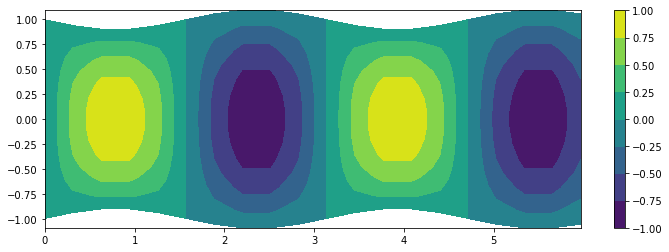

In [9]:
xx, yy = T.local_curvilinear_mesh()
plt.figure(figsize=(12, 4))
plt.contourf(xx, yy, uj.real)
plt.colorbar()

Inspect the sparsity pattern of the generated matrix on the left hand side

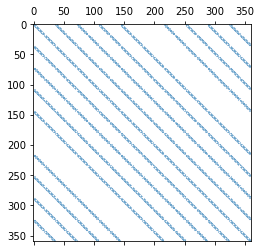

In [10]:
from matplotlib.pyplot import spy
plt.figure()
spy(Sol1.M, markersize=0.1)